In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn

/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
train_edata=EMNIST(root='emnist_dataset/train/',split='balanced',train=True,download=True,transform=ToTensor())
test_edata=EMNIST(root='emnist_dataset/test/',split='balanced',train=False,download=True,transform=ToTensor())
train_edata,test_edata

(Dataset EMNIST
     Number of datapoints: 112800
     Root location: emnist_dataset/train/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 18800
     Root location: emnist_dataset/test/
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Making Dataloader

In [3]:
train_dataloader=DataLoader(train_edata,256,shuffle=True,num_workers=4)
test_dataloader=DataLoader(test_edata,256,shuffle=True,num_workers=4)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a2058e41430>,
 <torch.utils.data.dataloader.DataLoader at 0x7a2058df5ee0>)

## Extracting Number of Input Features and Number of Output Classes

In [4]:
img,label=next(iter(train_dataloader))

num_input_feat=(img.squeeze(1).flatten(1,2)).shape[1]
num_output=len(train_edata.class_to_idx)

print(f"Number of input features: {num_input_feat}\
      \nNumber of output classes: {num_output}")

Number of input features: 784      
Number of output classes: 47


## Buiding a Model

In [5]:
class Layernorm(nn.Module):

    def __init__(self,num_input_feat,num_output):
        
        super().__init__()
        self.num_input_feat=num_input_feat
        self.num_output=num_output
        self.num_hidden=128

        self.model=nn.Sequential(
        nn.Linear(self.num_input_feat,self.num_hidden),
        nn.Tanh(),
        nn.LayerNorm(self.num_hidden),
        nn.Linear(self.num_hidden,self.num_output),
        )
        
    def forward(self,x):
        return self.model(x)


In [6]:
model1=Layernorm(num_input_feat,num_output)
model1

Layernorm(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=128, out_features=47, bias=True)
  )
)

## Loss Function and Optimizer

In [8]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.01)

In [9]:
loss_train_mean=[]
loss_test_mean=[]

In [10]:
for epoch in range(30):
    loss_list_train=[]
    loss_list_test=[]
    for img,label in train_dataloader:
        model1.train()

        out=model1((img.squeeze(1).flatten(1,2))/255)
        # logits=(torch.softmax(out,dim=1)).argmax(dim=1)

        loss=loss_fn(out,label)
        loss_list_train.append(loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    model1.eval()
    for img_test,label_test in test_dataloader:
        test_out=model1((img_test.squeeze(1).flatten(1,2))/255)
        loss_test=loss_fn(test_out,label_test)
        loss_list_test.append(loss_test.item())


    loss_train_mean.append(sum(loss_list_train)/len(loss_list_train))
    loss_test_mean.append(sum(loss_list_test)/len(loss_list_test))


## Saving the Model

In [11]:
torch.save(model1.state_dict(), 'layernorm_lib.pt')

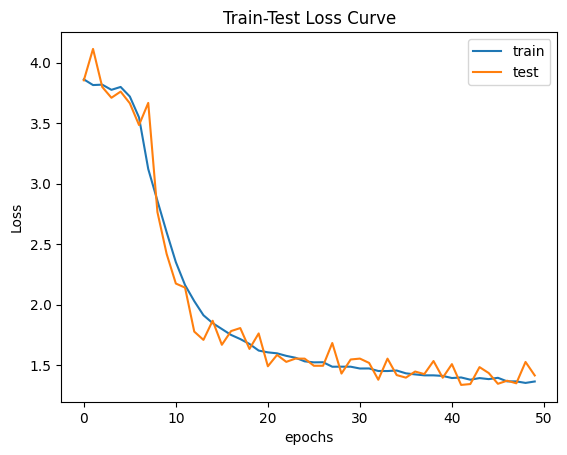

In [12]:
plt.plot(loss_train_mean,label='train')
plt.plot(loss_test_mean,label='test')
plt.xlabel("epochs")
plt.ylabel('Loss')
plt.title("Train-Test Loss Curve")
plt.legend()
plt.show()

## Loading the Model


In [7]:
model1.load_state_dict(torch.load('layernorm_lib.pt'))
model1.eval()

Layernorm(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=128, out_features=47, bias=True)
  )
)

## Train-Test Accuracy

In [8]:
X_etrain=torch.flatten(train_edata.data,1,2).to(torch.float32)
Y_etrain=(train_edata.targets.reshape(X_etrain.shape[0],1).to(torch.int8))


out=model1(X_etrain/255)
prediction_train=(torch.softmax(out,dim=1)).argmax(dim=1)

# 
# train_accuracy



In [9]:
train_accuracy=torch.sum(torch.where(prediction_train==train_edata.targets,1,0))/Y_etrain.shape[0]
train_accuracy

tensor(0.4322)